# Applying MHW defintion to NOW data

This has the code required to calculate the 90th percetnile and climatology required by the Hobday (2016) paper.

Here we import the needed modules, and initialize a dask cluster. 

In [1]:
import xarray as xr
import now
import numpy as np
import time
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
import marineHeatWaves as mhw
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
local_dir = "/g/data1a/e14/rm6294/dask-workers"
cluster = LocalCluster(processes=False, local_dir=local_dir)
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.10/1968/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


## Reading in NOW data
This block reads in the SST from the NOW data, and splits up the past and future runs.

In [3]:
cfg = 'present_vs_future.ini'
gridT = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')

## Applying MHW functions
The MHW code takes in 1D SST and time data. The NOW SST data (`sstPast` and `sstFuture`) are both 3D dimensional arrays, with 2D for position and 1D for time. Thus we have to run the mhw code multiple times, looping over each grid point (each latitude and longitude point).

In [4]:
# NOW data is daily, and runs from 1990/01/01T12:00:00 to 2008/12/31T12:00:00. We use this to create our t vector.

#Two lines below taken from example_synthetic file in MHW github
t = np.arange(date(1990,1,1).toordinal(),date(2008,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

## Sandbox area

##### Here, we try an approach pioneered by Guilluame. We group the data by day of year, and then run mean etc to find relevant statistics.

In [5]:
sst_reshaped = xr.open_zarr('/g/data1/e14/gs9353/POST-PROCESS/MHWs/SST_per_dayofyear_Present_vs_Future.zarr')['tos'].sel(simulation='Present')
sst_reshaped = sst_reshaped.isel(dayofyear = slice(0,-1)) # Removes day 366
#The following circularises the data, making rolling window processes possible.
start = sst_reshaped[:5]
start['dayofyear'] = range(366,371)
end = sst_reshaped[-5:]
end['dayofyear'] = range(-4, 1)

circular_sst = xr.concat([end, sst_reshaped, start], dim = 'dayofyear')



###### We have the background climatology, but now need the threshold. This area will tackle that:

In [170]:
%%time
## Our approach
trial = circular_sst.isel(x = slice(10,40), y = slice(10,40))
trial_thresh_smooth = trial.rolling(dayofyear=10, center=True).construct('rolling_days')

trials = trial_thresh_smooth.quantile(0.9, dim = ["rolling_days", "year"])

a = trial_thresh_smooth.stack(z = ('rolling_days', 'year'))
trials_fat = a.quantile(0.9,dim = 'z')
trials = trials_fat.isel(dayofyear = slice(5,-5))

UsageError: Line magic function `%%time` not found.


In [171]:
trial_thresh_smooth = trial.rolling(dayofyear=10, center=True).construct('rolling_days')
a = trial_thresh_smooth.stack(z = ('rolling_days', 'year'))
print(a.data)

dask.array<reshape, shape=(376, 20, 20, 190), dtype=float32, chunksize=(100, 20, 20, 76)>


In [172]:
new = da.array.apply_along_axis(np.nanpercentile, a.get_axis_num('z'), a.data, 90)

In [173]:
res = new.compute()

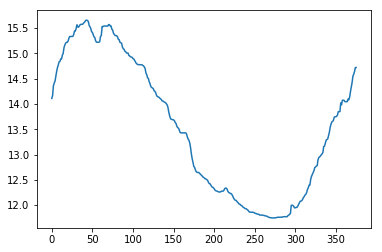

In [174]:
plt.plot(res[:, 1, 1]);

In [184]:
sst_coords = trial.coords

In [192]:
sst_threshold = xr.DataArray(new, coords = new_coords, dims = new_dims)

In [ ]:
res = sst_threshold.compute()

In [ ]:
res.isel(x=1, y=1).plot()

CPU times: user 21.2 s, sys: 17.2 s, total: 38.4 s
Wall time: 5.93 s


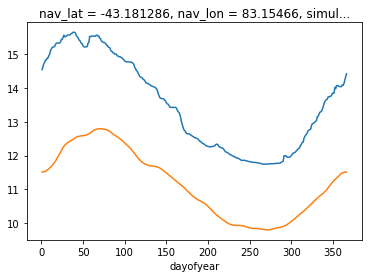

In [104]:
%%time
trials.isel(x = 1, y = 1).plot()
sst_climatology_smooth.isel(x = 1, y = 1).plot();

##### Here we try the brute force approach for a small area of the NOW data.

In [90]:
%%time 
# MHW code
ssta_structure = np.zeros((20, 20, 6940))
clim_structure = np.zeros((20, 20, 6940))
thresh_structure = np.zeros((20, 20, 6940))


ssta = xr.DataArray(ssta_structure, dims=['x', 'y', 'date'])
thresh = xr.DataArray(thresh_structure, dims=['x', 'y', 'date'])
clima = xr.DataArray(clim_structure, dims=['x', 'y', 'date'])

for i in range(2, 3):
    for j in range(2, 3):
        mhws, clim = mhw.detect(t, sstPast.isel(x = i, y = j))
        clima[i,j,:] = clim['seas']
        thresh[i,j,:] = clim['thresh']
        ssta[i,j, :] = sstPast.isel(x = i, y = j) - clim['seas']
       

Result:
Took Forever, and still only represented a tiny portion of data (see below), so this approach was shelved.

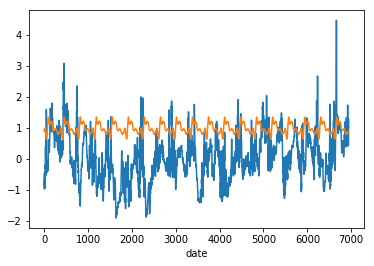

In [91]:
ssta.isel(x= 2, y= 2).plot();
thresha = thresh.isel(x= 2, y = 2) - clima.isel(x= 2, y= 2)
thresha.plot();

# Measuring MHW code vs Our approach

In [6]:
sst_reshaped = xr.open_zarr('/g/data1/e14/gs9353/POST-PROCESS/MHWs/SST_per_dayofyear_Present_vs_Future.zarr')['tos'].sel(simulation='Present')
sst_reshaped = sst_reshaped.isel(dayofyear = slice(0,-1)) # Removes day 366
gridStart = 10
gridFin = 29

In [18]:
trial = circular_sst.isel(x = slice(gridStart,gridFin), y = slice(gridStart,gridFin))
trial_thresh_smooth = trial.rolling(dayofyear=11, center=True).construct('rolling_days')
trial_thresh_noSmooth = trial.rolling(dayofyear=1, center=True).construct('rolling_days')

a = trial_thresh_smooth.stack(z = ('rolling_days', 'year'))
a_noSmooth = trial_thresh_noSmooth.stack(z = ('rolling_days', 'year'))

new = da.array.apply_along_axis(np.nanpercentile, a.get_axis_num('z'), a.data, 90)
new_noSmooth = da.array.apply_along_axis(np.nanpercentile, a_noSmooth.get_axis_num('z'), a.data, 90)

sst_coords = circular_sst.coords
new_coords = {name : sst_coords[name] for name in sst_coords if name != 'year'}
new_dims = [name for name in trial.dims if name != 'year']

res = xr.DataArray(new, coords = new_coords, dims = new_dims)
res_noSmooth = xr.DataArray(new_noSmooth, coords = new_coords, dims = new_dims)

sst_threshold_fat = res.compute().rolling(dayofyear=31, center = True).mean()
sst_threshold_fat_noSmooth = res_noSmooth.compute()

sst_threshold = sst_threshold_fat.isel(dayofyear = slice(31,-31))
sst_threshold_noSmooth = sst_threshold_fat_noSmooth.isel(dayofyear = slice(31,-31))

In [27]:
%%time
## Our approach
## This code produces two clims and two thresholds. One has a 10 day smoothing window (smooth), while the other
## has no window (noSmooth).

start = sst_reshaped[:31]
end = sst_reshaped[-31:]

circular_sst = xr.concat([end, sst_reshaped, start], dim = 'dayofyear')

#Climatology
sst_climatology_raw = circular_sst.isel(x = slice(gridStart,gridFin), y = slice(gridStart,gridFin)).mean('year')

sst_climatology_noSmooth_fat = sst_climatology_raw.rolling(dayofyear=1, center=True).mean()
sst_climatology_smooth_fat = sst_climatology_raw.rolling(dayofyear=11, center=True).mean()

sst_climatology = sst_climatology_smooth_fat.rolling(dayofyear=31, center = True).mean().isel(dayofyear = slice(31,-31))
sst_climatology_noSmooth = sst_climatology_noSmooth_fat.isel(dayofyear = slice(31,-31))

#Threshold
trial = circular_sst.isel(x = slice(gridStart,gridFin), y = slice(gridStart,gridFin))
trial_thresh_smooth = trial.rolling(dayofyear=11, center=True).construct('rolling_days')
trial_thresh_noSmooth = trial.rolling(dayofyear=1, center=True).construct('rolling_days')

a = trial_thresh_smooth.stack(z = ('rolling_days', 'year'))
a_noSmooth = trial_thresh_noSmooth.stack(z = ('rolling_days', 'year'))

new = da.array.apply_along_axis(np.nanpercentile, a.get_axis_num('z'), a.data, 90)
new_noSmooth = da.array.apply_along_axis(np.nanpercentile, a_noSmooth.get_axis_num('z'), a.data, 90)

sst_coords = trial.coords
new_coords = {name : sst_coords[name] for name in sst_coords if name != 'year'}
new_dims = [name for name in trial.dims if name != 'year']

res = xr.DataArray(new, coords = new_coords, dims = new_dims)
res_noSmooth = xr.DataArray(new_noSmooth, coords = new_coords, dims = new_dims)

sst_threshold_fat = res.compute().rolling(dayofyear=31, center = True).mean()
sst_threshold_fat_noSmooth = res_noSmooth.compute()

sst_threshold = sst_threshold_fat.isel(dayofyear = slice(31,-31))
sst_threshold_noSmooth = sst_threshold_fat_noSmooth.isel(dayofyear = slice(31,-31))


CPU times: user 2min 53s, sys: 1min 39s, total: 4min 33s
Wall time: 2min 8s


In [37]:
sst_threshold.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/newSmoothThresh.ni')
#sst_climatology.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/newSmoothClim.ni')

In [36]:
sst_threshold.isel(x=1,y=1)

<xarray.DataArray (dayofyear: 365)>
array([14.558184, 14.60425 , 14.647652, ..., 14.42174 , 14.467493, 14.511734])
Coordinates:
    nav_lat     float32 -42.223953
    nav_lon     float32 86.98043
    simulation  <U7 'Present'
  * dayofyear   (dayofyear) int64 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

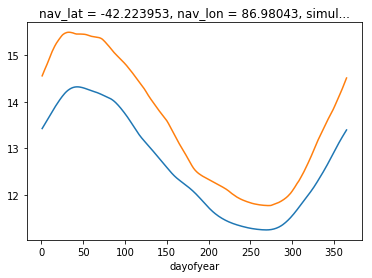

In [31]:
sst_climatology.isel(x=3, y=3).plot()
sst_threshold.isel(x=1, y=1).plot();

In [32]:
sst = gridT['tos'] 
# SST contains both future and past run. We now split that up.
sstPast = sst[0].load()
sstFut = sst[1]

In [150]:
%%time
## MHW approach

#ssta_structure = np.zeros((20, 20, 6940))
clim_structure = np.zeros((20, 20, 6940))
thresh_structure = np.zeros((20, 20, 6940))

#ssta = xr.DataArray(ssta_structure, dims=['x', 'y', 'date'])
thresh = xr.DataArray(thresh_structure, dims=['x', 'y', 'date'])
clima = xr.DataArray(clim_structure, dims=['x', 'y', 'date'])

for i in range(1, 20):
    for j in range(1, 20):
        mhws, clim = mhw.detect(t, sstPast.isel(x = i + 9, y = j + 9), smoothPercentile = False)
        clima[i,j,:] = clim['seas']
        thresh[i,j,:] = clim['thresh']
        
clima.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/oldNoSmoothClim.ni')
thresh.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/oldNoSmoothThresh.ni')

for i in range(1, 20):
    for j in range(1, 20):
        mhws, clim = mhw.detect(t, sstPast.isel(x = i + 9, y = j + 9))
        clima[i,j,:] = clim['seas']
        thresh[i,j,:] = clim['thresh']

clima.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/oldSmoothClim.ni')
thresh.to_netcdf('/g/data1a/e14/rm6294/testNOWMHWFiles/oldSmoothThresh.ni')

CPU times: user 42min 5s, sys: 1min 39s, total: 43min 44s
Wall time: 41min 13s


# Final Process: Finding Threshold and Climatology for entire Dataset

In [1]:
import xarray as xr
import now
import numpy as np
import time
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
import marineHeatWaves as mhw
%pylab inline
local_dir = "/g/data1a/e14/rm6294/dask-workers"
cluster = LocalCluster(processes=False, local_dir=local_dir)
client = Client(cluster)
client

Populating the interactive namespace from numpy and matplotlib


Client Scheduler: inproc://10.0.64.24/10114/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [2]:
sst_reshaped = xr.open_zarr('/g/data1/e14/gs9353/POST-PROCESS/MHWs/SST_per_dayofyear_Present_vs_Future_50x50.zarr')['tos'].sel(simulation='Present')
#sst_reshaped = sst_reshaped.isel(dayofyear = slice(0,-1)) # Removes day 366
#The following circularises the data, making rolling window processes possible.
#start = sst_reshaped[:31]
#start['dayofyear'] = range(366,397)
#end = sst_reshaped[-31:]
#end['dayofyear'] = range(-30, 1)

circular_sst = sst_reshaped
#circular_sst = circular_sst.chunk({'x' : 30, 'y' : 30, 'dayofyear' : 31})

In [3]:
circular_sst

<xarray.DataArray 'tos' (dayofyear: 427, year: 19, y: 289, x: 431)>
dask.array<shape=(427, 19, 289, 431), dtype=float32, chunksize=(427, 19, 50, 50)>
Coordinates:
  * dayofyear   (dayofyear) int64 -30 -29 -28 -27 -26 ... 392 393 394 395 396
    nav_lat     (y, x) float32 dask.array<shape=(289, 431), chunksize=(50, 50)>
    nav_lon     (y, x) float32 dask.array<shape=(289, 431), chunksize=(50, 50)>
    simulation  <U7 'Present'
  * year        (year) int64 1990 1991 1992 1993 1994 ... 2005 2006 2007 2008
Dimensions without coordinates: y, x
Attributes:
    interval_operation:  360s
    interval_write:      1d
    long_name:           sea_surface_temperature
    online_operation:    average
    units:               degC

In [11]:
%%time
#Climatology. Note no slicing, so we have the entire dataset: 
raw_sst = circular_sst.mean('year')
sst_climatology_smooth_fat = raw_sst.rolling(dayofyear= 11, center = True).mean()
sst_climatology = sst_climatology_smooth_fat.rolling(dayofyear=31, center = True).mean()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/

CPU times: user 1min 30s, sys: 2min 23s, total: 3min 54s
Wall time: 53.2 s


In [12]:
%%time
sst_climatology = sst_climatology.isel(dayofyear = slice(31,-31))
sst_climatology.to_netcdf('/g/data1a/e14/rm6294/NOWMHW/orig/pastClim.nc')

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 51.2 s, sys: 1min 46s, total: 2min 37s
Wall time: 1min 18s


In [4]:
#Threshold. Same here, no slicing:
trial_thresh_smooth = circular_sst.rolling(dayofyear=11, center=True).construct('rolling_days')

# This takes in the sst, performs the percentile calculation, then creates a new dimension and coordinate names 
# to prepapre the data for the final output
a = trial_thresh_smooth.stack(z = ('rolling_days', 'year'))
new = da.array.apply_along_axis(np.nanpercentile, a.get_axis_num('z'), a.data, 90)
sst_coords = circular_sst.coords
new_coords = {name : sst_coords[name] for name in sst_coords if name != 'year'}
new_dims = [name for name in circular_sst.dims if name != 'year']
res = xr.DataArray(new, coords = new_coords, dims = new_dims)

In [5]:
%%time
res.to_netcdf('/g/data1a/e14/rm6294/NOWMHW/orig/rawPercentiles.nc')

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


CPU times: user 5h 41min 16s, sys: 3h 7min 40s, total: 8h 48min 56s
Wall time: 5h 35min 14s


In [6]:
%%time
#Final rolling mean over a month
rawPerc = xr.open_dataset('/g/data1a/e14/rm6294/NOWMHW/orig/rawPercentiles.nc')
sst_threshold = rawPerc.rolling(dayofyear=31, center = True).mean()
print("Data smoothed, DONE.")
sst_threshold = sst_threshold.isel(dayofyear = slice(31,-31))
sst_threshold.to_netcdf('/g/data1a/e14/rm6294/NOWMHW/orig/pastThresh.nc')

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Data smoothed, DONE.
CPU times: user 18 s, sys: 13.4 s, total: 31.4 s
Wall time: 16.5 s
